### A close to paper implementation

#### I begin with the GPDriftFit
Since I want to stay close to the paper I replicate the driftfit described in appendix F.1

$$ 
[\tilde{\mathbf{u}}^+ (x,t)]_d = \mathrm{vec}(\mathbf{k}_d^+(x\oplus t))^T(\tilde{\mathbf{K}}_d^+ + \frac{\gamma}{\Delta t} \mathbb{I}_{MT})^{-1}\mathrm{vec}(\mathbf{Y^+_d}), \\
\\
[\tilde{\mathbf{u}}^- (x,t)]_d = \mathrm{vec}(\mathbf{k}_d^-(x\oplus t))^T(\tilde{\mathbf{K}}_d^- + \frac{\gamma}{\Delta t} \mathbb{I}_{NT})^{-1}\mathrm{vec}(\mathbf{Y^-_d}), \\
~\\
[\tilde{\mathbf{K}}^{\pm}_d]_{i\cdot T +l, i'\cdot T + l'} = [\mathbf{K}^{\pm}_d]_{ii'll'},\\
[\mathbf{K}^{+}_d]_{mm'll'} = K_d(\mathbf{x}_{t_l -\Delta t}^{(m)-}\oplus (t_l - \Delta t), \mathbf{x}_{t_{l'} -\Delta t}^{(m')-}\oplus (t_{l'} - \Delta t)), \\
[\mathbf{K}^{-}_d]_{nn'kk'} = K_d(\mathbf{x}^{(n)+}_{t_k} \oplus t_k, \mathbf{x}_{t_{k'}}^{(n')+}\oplus t_{k'}),\\
\\
[\mathbf{k}_d^+(\mathbf{x}\oplus t)]_{lm} = K_d(\mathbf{x} \oplus t,\mathbf{x}^{(m)-}_{t_l - \Delta t} \oplus (t_l - \Delta t)),
\\
[\mathbf{k}_d^-(\mathbf{x}\oplus t)]_{kn} = K_d(\mathbf{x}\oplus t, \mathbf{x}_{t_k}^{(n)-}\oplus (t_k)),
\\
[\mathbf{Y}_d^\pm]_{li} = \left[\frac{\pm\mathbf{x}^{(i)\mp}_{t_l} \mp \mathbf{x}^{(i)\mp}_{t_l - \Delta t}}{\Delta t} \right]_d
$$


In [68]:
import numpy as np

''' Make a kernel '''
sigma = 2.5
# Exp
#K = lambda x, xp: np.exp(-np.linalg.norm(x-xp) / (2*sigma**2))
# RBF
K = lambda x, xp: np.exp(-np.linalg.norm(x-xp)**2 / (2*sigma**2)) 


''' Implement Y '''
def Y(series, times, dir='+'):
    dts = np.diff(times, axis=0)
    diffs = np.diff(series, axis=0)
    y_ds = diffs / dts                      # (T-1, N)

    # Produce index shifted predictors
    if dir == '+':
        xs, ts = series[:-1, :], times[:-1, :]
    else:
        xs, ts = series[1:, :], times[1:, :]

    Y_vec = y_ds.flatten(order='F').T
    X_vec = np.hstack([xs.flatten(order='F').T,
                       ts.flatten(order='F').T])

    return Y_vec, X_vec


''' Implement k_d '''
class k:
    def __init__(self, X, kernel=K):
        self.X = X              
        self.kernel = kernel

    def evalm(self, x, t):
        k_vec = np.zeros(self.X.shape[0])
        xt = np.asmatrix([x, t])
        for i in range(self.X.shape[0]):
            k_vec[i] = self.kernel(xt, self.X[i, :])    # Calculate k_lm, since we already flattened out the m dimension just run over combined l,m
        return np.asmatrix(k_vec).T


''' Implement K '''
class K_tilde:
    def __init__(self, X, kernel=K):
        self.X = X
        self.kernel = kernel

    def evalK(self):
        M = self.X.shape[0]
        Kmat = np.zeros((M, M))
        
        for i in range(M):
            for j in range(i, M):                # Leverage symmetry and compute only upper half
                Kmat[i, j] = self.kernel(self.X[i, :], self.X[j, :])    # Similarity matrix between all points
                if i != j:
                    Kmat[j, i] = Kmat[i, j]     

        return Kmat

''' Implement u '''
def predict(x, t, dir, series, times, kernel=K, gamma=0.1, deltaT=0.1):
    Y_vec, X_vec = Y(series, times, dir)

    k_gen = k(X_vec, kernel)
    K_gen = K_tilde(X_vec, kernel)

    k_vec = k_gen.evalm(x, t)
    K_til = K_gen.evalK()
    I = np.identity(K_til.shape[0])

    mean = k_vec.T @ np.linalg.inv(K_til + (gamma/deltaT)*I) @ Y_vec
    return mean


def predictor(dir, series, times, kernel=K, gamma=1.0, deltaT=0.1):
    Y_vec, X_vec = Y(series, times, dir)

    k_gen = k(X_vec, kernel)
    K_gen = K_tilde(X_vec, kernel)

    K_til = K_gen.evalK()
    I = np.identity(K_til.shape[0])

    tail = np.linalg.solve(K_til + (gamma/deltaT)*I, Y_vec) # Solve with context is much better than .inv in terms of stability and speed

    return lambda x, t: (k_gen.evalm(x, t).T @ tail).item()


##### Test the prediction routine

In [69]:
series = np.asmatrix([[0, 1, 3, 4], [1, 2, 4, 5]]).T
times = np.asmatrix([[0, 1, 2, 3], [0, 1, 2, 3]]).T
deltaT = 1
predict(1,1,'+',series=series, times=times, kernel=K, deltaT=deltaT)

matrix([[1.69099646]])

### Create a dummy bridge to learn

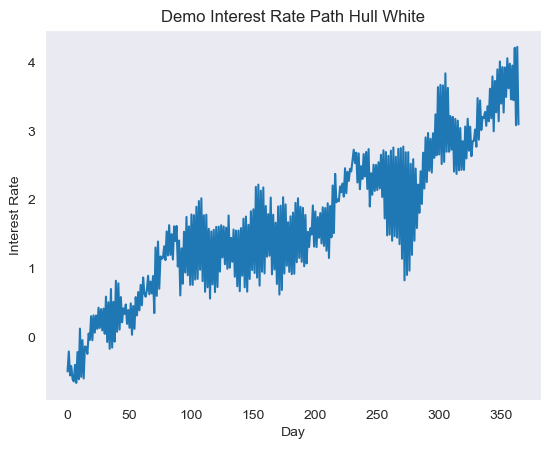

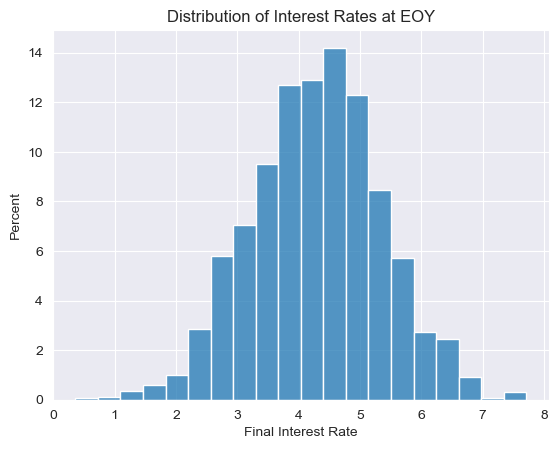

In [70]:
from numpy.random import normal as normal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from random import choices as draw
from itertools import chain

## Hull White Model
theta = 5 # Stasis rate 500%
alpha = 4 # Juiced Return Rate
sigma = 3
dt = 1/365 # Daily updates

hw = lambda r: r + alpha*(theta - r)*dt + sigma*np.sqrt(dt)*normal()
r0 = -0.5 # Initial interest rate of -50% means that we will see an expected drift up

rs = [r0]
for i in range(364):
    rs.append(hw(rs[i-1]))

plt.plot(rs)
plt.title('Demo Interest Rate Path Hull White')
plt.ylabel('Interest Rate')
plt.xlabel('Day')
plt.grid()
plt.show()

## Generate 2000 paths for an empirical set of end points
def generatePath():
    rs = [normal(r0, (sigma/2)**2)]
    for i in range(364):
        rs.append(hw(rs[i-1]))
    return rs

paths = [generatePath() for i in range(2000)]
end_data = [path[-1] for path in paths]
start_data = [path[0] for path in paths]
sb.histplot(end_data, bins = 20, stat = 'percent');
plt.xlabel('Final Interest Rate');
plt.title('Distribution of Interest Rates at EOY');
plt.show()

In [ ]:
## Now we Drop The Pathwise info completely, and keep only the edges
#paths.clear()
frames = {'start': start_data, 'end': end_data}

## And fit the Schrodinger Bridge by iterated MLE, using the GPDriftFit
numSamples = 400
schrodSteps = 5
N = 10
T = 1

def solveSDE(x0s, t0 = 0, T = T, func = lambda x,t: 0, steps = N, sigma = sigma/4):
    deltaT = (T-t0)/steps
    times = np.arange(t0,T+deltaT,deltaT)
    x_list = []
    for x0 in x0s:
        xs = [x0]
        for i in np.arange(1,steps+1):
            xs.append(xs[i-1] + deltaT*func(xs[i-1],times[i-1]) + sigma*np.sqrt(np.abs(deltaT))*normal())
        x_list.append(xs)
    return x_list, [times for x in x0s]

forwardFunc = lambda x,t: np.mean(end_data)-np.mean(start_data)

for i in range(1,schrodSteps+1):
    forwardPaths, forwardTimes = solveSDE(draw(frames['start'],k=numSamples), func = forwardFunc,)
    forwardPaths = np.asmatrix(forwardPaths).T
    forwardTimes = np.asmatrix(forwardTimes).T

    backwardFunc = predictor('-', forwardPaths, forwardTimes, deltaT=T/N, gamma=0.01)
    backwardsPaths, backwardsTimes = solveSDE(draw(frames['end'],k=numSamples), func = backwardFunc, T = 0, t0 = 1)
    backwardsPaths = np.asmatrix(backwardsPaths).T
    backwardsTimes = np.asmatrix(backwardsTimes).T

    forwardFunc = predictor('+', backwardsPaths, backwardsTimes, deltaT=T/N, gamma=0.01)

    print(i)

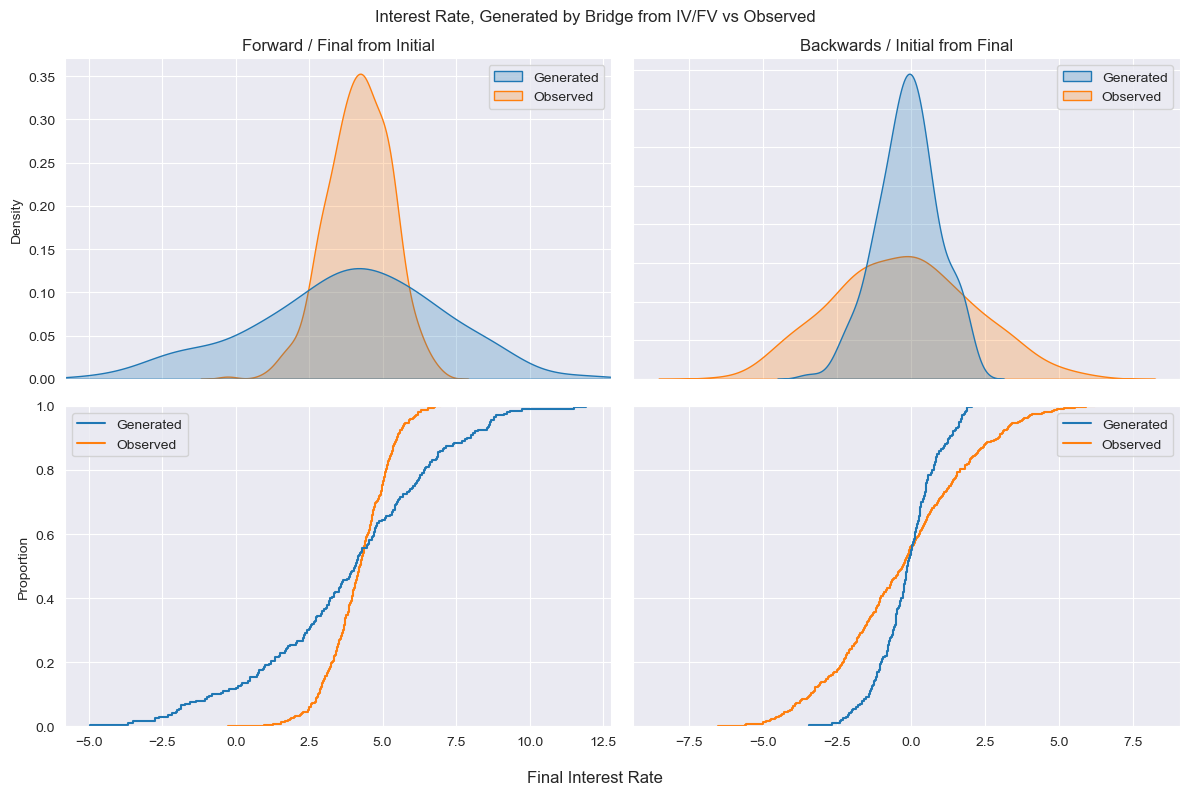

In [ ]:
def shareax(ax1,ax2):
    ax1.sharex(ax2)
    #ax1.sharey(ax2)
    ax1.relim()
    ax1.autoscale_view()
    ax1.label_outer()
    ax2.label_outer()

fdummies, _ = solveSDE(draw(frames['start'],k=200), func = forwardFunc)
f_final = [d[-1] for d in fdummies]
bdummies, _ = solveSDE(draw(frames['end'],k=200), func = backwardFunc, T = 0, t0 = 1)
d_initial = [d[-1] for d in bdummies]

fig, axes = plt.subplots(2,2,figsize = (12,8))
fig.set_layout_engine('tight')
sb.set_style("darkgrid")
sb.kdeplot({'Generated': f_final,'Observed':frames['end'][0:500]}, ax=axes[0,0], fill=True, common_norm=False);
sb.ecdfplot({'Generated': f_final,'Observed':frames['end'][0:500]}, ax = axes[1,0])
sb.kdeplot({'Generated': d_initial,'Observed':frames['start'][0:500]}, ax=axes[0,1],fill=True, common_norm=False,);
sb.ecdfplot({'Generated': d_initial,'Observed':frames['start'][0:500]}, ax = axes[1,1])
fig.supxlabel('Final Interest Rate');
fig.suptitle('Interest Rate, Generated by Bridge from IV/FV vs Observed')
shareax(axes[0,0],axes[1,0])
shareax(axes[1,1],axes[0,1])
axes[0,0].set_title('Forward / Final from Initial');
axes[0,1].set_title('Backwards / Initial from Final');
plt.show()

'''' Seems to be effectively shifting the mean, but not the variance... '''